In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
import os
import random
import copy
import time

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split

### Loading Commodities data

In [14]:
# Crude Oil : CL=F
# Natural Gas : NG=F
# Gold : GC=F
# Silver : SI=F
# Copper : HG=F
# S&P 500 : ^GSPC
# Dow Jones : ^DJI

ticker = "GC=F"
start = "2023-01-01"
end = "2024-01-01"
interval = "1d"

data = yf.download(ticker, start=start, end=end, interval=interval)
data.columns = data.columns.droplevel(1)  

print(data.head())

[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open  Volume
Date                                                                  
2023-01-03  1839.699951  1839.699951  1836.199951  1836.199951      29
2023-01-04  1852.800049  1859.099976  1845.599976  1845.599976      25
2023-01-05  1834.800049  1855.199951  1834.800049  1855.199951      24
2023-01-06  1864.199951  1868.199951  1835.300049  1838.400024      26
2023-01-09  1872.699951  1880.000000  1867.000000  1867.000000      62


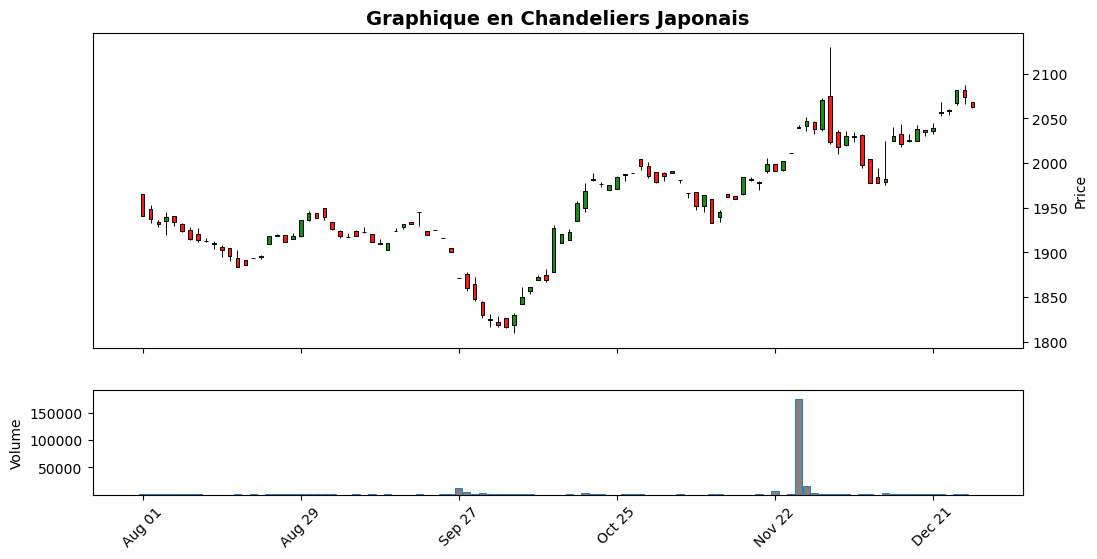

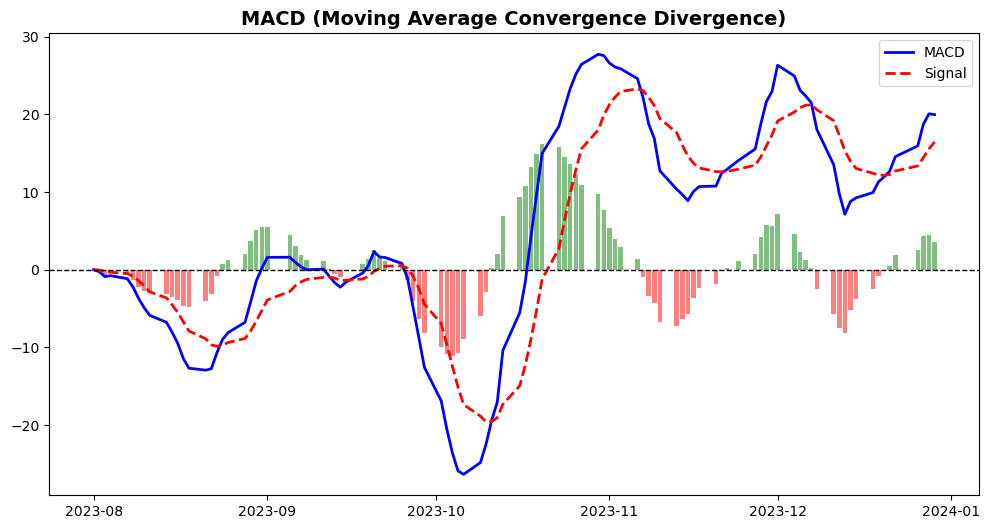

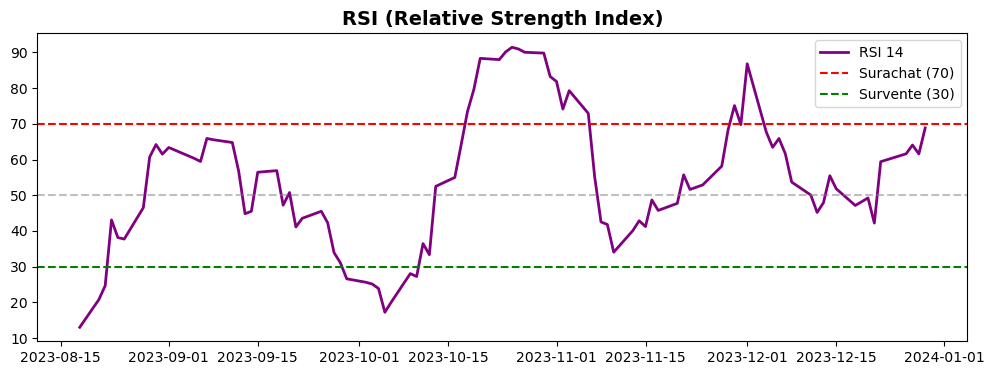

In [4]:
def plot_candlestick(data):
    """
    Affiche un graphique en chandelier avec un style moderne et épuré.
    """
    mc = mpf.make_marketcolors(up='green', down='red', wick='black', edge='black', volume='gray')
    s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)

    fig, (ax, ax_volume) = plt.subplots(2, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    mpf.plot(data, type='candle', style=s, ax=ax, volume=ax_volume)
    
    ax.set_title("Graphique en Chandeliers Japonais", fontsize=14, fontweight='bold')
    
    plt.show()


def plot_macd(data, short_window=12, long_window=26, signal_window=9):
    """
    Affiche le MACD avec sa ligne de signal et son histogramme.
    """
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
 
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()

    histogram = macd - signal
 
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(data.index, macd, label="MACD", color='blue', linewidth=2)
    ax.plot(data.index, signal, label="Signal", color='red', linestyle='dashed', linewidth=2)
    ax.bar(data.index, histogram, color=np.where(histogram > 0, 'green', 'red'), alpha=0.5)
    
    ax.axhline(0, color='black', linewidth=1, linestyle='--')  # Ligne horizontale zéro
    ax.set_title("MACD (Moving Average Convergence Divergence)", fontsize=14, fontweight='bold')
    ax.legend()
    plt.show()

def plot_rsi(data, window=14):
    """
    Affiche le RSI (Relative Strength Index) avec une période donnée.
    """
    # Calcul du RSI
    delta = data['Close'].diff(1)
    gain = np.where(delta > 0, delta, 0) 
    loss = np.where(delta < 0, -delta, 0) 

    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(data.index, rsi, label=f'RSI {window}', color='purple', linewidth=2)
    ax.axhline(70, linestyle='dashed', color='red', label='Surachat (70)')
    ax.axhline(30, linestyle='dashed', color='green', label='Survente (30)')
    ax.axhline(50, linestyle='dashed', color='gray', alpha=0.5) 

    ax.set_title("RSI (Relative Strength Index)", fontsize=14, fontweight='bold')
    ax.legend()
    plt.show()

plot_candlestick(data)
plot_macd(data)
plot_rsi(data)


### Feature Engineering

In [15]:
def compute_rsi(series, period=14):
    """
    Calcule manuellement le RSI (Relative Strength Index).
    RSI = 100 - 100 / (1 + RS)
    RS = moyenne_pondérée_exponentielle(gains) / moyenne_pondérée_exponentielle(pertes)
    """
    delta = series.diff(1).dropna()
    gains = delta.where(delta > 0, 0.0)
    losses = -delta.where(delta < 0, 0.0)

    avg_gain = gains.ewm(com=period-1, min_periods=period).mean()
    avg_loss = losses.ewm(com=period-1, min_periods=period).mean()

    rs = avg_gain / (avg_loss + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    # Ré-alignement
    rsi = rsi.reindex(series.index, method='bfill').fillna(method='bfill')
    return rsi

def compute_ema(series, period=12):
    """Calcule une EMA (Exponential Moving Average)."""
    return series.ewm(span=period, adjust=False).mean()

# Ajoutons RSI et EMA au DataFrame
data["RSI"] = compute_rsi(data["Close"], period=14)
data["EMA12"] = compute_ema(data["Close"], period=12)
data.dropna(inplace=True)

C:\Users\planc\AppData\Local\Temp\ipykernel_3916\1137775761.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rsi = rsi.reindex(series.index, method='bfill').fillna(method='bfill')


### Designing Environnement

In [57]:
class Environment:
    """
    Environnement simplifié de trading sur l'or.
    - Actions discrètes : 0=stay, 1=buy, 2=sell
    - On maintient une liste des positions ouvertes, on calcule le profit
      lorsque l'on vend (2), etc.
      
    Variables description:
    - self.df : DataFrame avec les données historiques
    - self.history_t : taille de la fenêtre historique
    - self.features : liste des colonnes à utiliser
    - self.t : indice temporel actuel
    - self.done : booléen, True si la simulation est terminée
    - self.profits : gains cumulés
    - self.positions : liste des positions ouvertes (prix d'achat pas encore cloturé)
    - self.position_value : valeur actuelle des positions ouvertes. Il s'agit du gain ou la perte potentielle si l agent vendait 
                            immédiatement toutes ses positions ouvertes.
    - self.history : liste des variations de prix (Close_t - Close_t-1) sur les derniers jours (pour l'observation)
    -obs : observation actuelle (position_value, history..., Close(t), RSI(t), EMA12(t))
    -reward : récompense pour l'action précédente
    """

    def __init__(self, df, history_t=30):
        """
        :param df: DataFrame avec colonnes ['Open','High','Low','Close','RSI','EMA12']
        :param history_t: taille de la fenêtre historique
        """
        self.df = df.copy().reset_index(drop=True)
        self.history_t = history_t
        self.features = ["Close", "RSI", "EMA12"]
        self.reset()

    def reset(self):
        """
        Remet l'environnement à zéro :
         - t = 0
         - profits = 0
         - positions = []
         - position_value = 0
         - history -> [0]*history_t
        """
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0.0] * self.history_t

        return self._get_obs()

    def _get_obs(self):
        """
        Construit l'observation : 
        [position_value, history..., Close(t), RSI(t), EMA12(t)]
        """
        row = self.df.iloc[self.t]
        feats = [
            float(row["Close"]),
            float(row["RSI"]) if not pd.isnull(row["RSI"]) else 0.0,  # Correction ici
            float(row["EMA12"])
        ]
        obs = [self.position_value] + self.history + feats
        return np.array(obs, dtype=np.float32)


    def step(self, act):
        """
        Exécute l'action (0=stay,1=buy,2=sell).
        Retourne : obs, reward, done
        """
        reward_raw = 0.0
        reward = 0
        fee_rate = 0.001

        # Exécution
        if act == 1:
            # buy
            self.positions.append(self.df.iloc[self.t]["Close"])
        elif act == 2:
            # sell
            if len(self.positions) == 0:
                reward_raw = -1.0  # Pénalité si on vend sans position
            else:
                # Gains cumulés
                profits = 0.0
                current_price = self.df.iloc[self.t]["Close"]
                for p in self.positions:
                    profits += (current_price - p)
                # Calcul des frais pour toutes les positions
                transaction_cost = fee_rate * current_price * len(self.positions)
                profits -= transaction_cost
                reward_raw = profits
                self.profits += profits
                self.positions = []  # On ferme toutes les positions

        # Avancer dans le temps
        self.t += 1
        if self.t >= len(self.df) - 1:
            self.done = True

        # Calcul de la position latente
        self.position_value = 0.0
        if len(self.positions) > 0:
            current_price = self.df.iloc[self.t]["Close"]
            for p in self.positions:
                self.position_value += (current_price - p)

        # Mettre à jour l'historique
        if self.t > 0:
            price_diff = self.df.iloc[self.t]["Close"] - self.df.iloc[self.t - 1]["Close"]
        else:
            price_diff = 0.0
        self.history.pop(0)
        self.history.append(price_diff)

        # Reward final (clip)
        if reward_raw > 0:
            reward = 1.0
        elif reward_raw < 0:
            reward = -1.0
        else:
            reward = 0.0

        return self._get_obs(), reward, self.done, reward_raw

### Designing Agent

In [77]:
class QLearningTrader:
    """
    Met en place un DQN simple en PyTorch pour entraîner un agent
    sur l'environnement GoldTradingEnv.
    """

    # --- Le réseau de neurones ---
    class QNetwork(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super().__init__()
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, hidden_dim)
            self.fc3 = nn.Linear(hidden_dim, output_dim)

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    def __init__(
        self,
        env: Environment,
        hidden_dim=64,
        gamma=0.95,
        lr=1e-3,
        memory_size=200,
        batch_size=32,
        eps_start=1.0,
        eps_min=0.1,
        eps_decay=1e-3,
        update_target_freq=50,
        train_freq=10
    ):
        """
        :param env: Environnement (Environment)
        :param hidden_dim: taille des couches cachées
        :param gamma: discount factor
        :param lr: learning rate pour Adam
        :param memory_size: taille du buffer d'expérience
        :param batch_size: taille du batch
        :param eps_start, eps_min, eps_decay: pour l'epsilon-greedy
        :param update_target_freq: fréquence de copie du réseau principal vers le réseau cible
        :param train_freq: fréquence d'entraînement (en nombre de steps)
        """
        self.env = env
        sample_obs = self.env.reset()
        self.input_dim = len(sample_obs)
        self.hidden_dim = hidden_dim
        self.output_dim = 3  # stay, buy, sell -> 0, 1, 2

        self.gamma = gamma
        self.lr = lr
        self.memory_size = memory_size
        self.batch_size = batch_size

        self.eps = eps_start
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.update_target_freq = update_target_freq
        self.train_freq = train_freq

        # Réseaux
        self.policy_net = self.QNetwork(self.input_dim, hidden_dim, self.output_dim)
        self.target_net = copy.deepcopy(self.policy_net)

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

        # Mémoire de replay : [(pobs, act, reward, obs, done), ...]
        self.memory = []
        self.total_steps = 0

    def select_action(self, obs):
        """
        Sélection d'action via epsilon-greedy.
        """
        if random.random() < self.eps:
            return random.randint(0, self.output_dim - 1)
        obs_t = torch.FloatTensor(obs).unsqueeze(0)
        with torch.no_grad():
            q_vals = self.policy_net(obs_t)
        return q_vals.argmax(dim=1).item()

    def update_epsilon(self):
        """
        Baisse epsilon linéairement jusqu'à eps_min.
        """
        if self.eps > self.eps_min:
            self.eps -= self.eps_decay
            if self.eps < self.eps_min:
                self.eps = self.eps_min

    def store_transition(self, pobs, act, reward, obs, done):
        """
        Stocke la transition dans le buffer.
        """
        self.memory.append((pobs, act, reward, obs, done))
        if len(self.memory) > self.memory_size:
            self.memory.pop(0)

    def train_step(self):
        """
        Un pas d'entraînement : on échantillonne un batch, on calcule la loss,
        et on met à jour policy_net.
        """
        if len(self.memory) < self.batch_size:
            return 0.0

        batch = random.sample(self.memory, self.batch_size)
        pobs, acts, rewards, obs_, dones = zip(*batch)
        pobs_t = torch.FloatTensor(pobs)
        acts_t = torch.LongTensor(acts)
        rewards_t = torch.FloatTensor(rewards)
        obs_t = torch.FloatTensor(obs_)
        dones_t = torch.BoolTensor(dones)

        # Q(s, a) du réseau policy_net
        q_vals = self.policy_net(pobs_t)
        # On ne prend que la Q-valeur de l'action réelle
        q_val = q_vals.gather(1, acts_t.unsqueeze(1)).squeeze(1)

        # Q-target : r + gamma * max(Q') (avec target_net)
        with torch.no_grad():
            q_next = self.target_net(obs_t)
            q_next_max, _ = q_next.max(dim=1)
            q_target = rewards_t + (self.gamma * q_next_max * (~dones_t))

        loss = nn.MSELoss()(q_val, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def update_target(self):
        """
        Copie policy_net -> target_net
        """
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def train(self, epochs=10):
        """
        Boucle d'entraînement sur un certain nombre d'épisodes (epochs).
        """
        step_max = len(self.env.df) - 1
        show_log_freq = max(1, epochs // 5)

        rewards_history = []
        rewards_raw_history = []
        losses_history = []

        # Stocke les profits nets journaliers
        daily_profits = {}

        start_time = time.time()
        for epoch in range(epochs):
            obs = self.env.reset()
            done = False
            ep_reward = 0.0
            ep_reward_raw = 0.0
            ep_loss = 0.0
            step = 0

            # Initialiser la date actuelle et la liste des profits nets du jour
            current_date = self.env.t
            daily_profits[current_date] = []

            while not done and step < step_max:
                act = self.select_action(obs)
                next_obs, reward, done, reward_raw = self.env.step(act)

                # Enregistrer le profit net du trade dans la date correspondante
                trade_date = self.env.t
                if trade_date not in daily_profits:
                    daily_profits[trade_date] = []
                daily_profits[trade_date].append(reward_raw)

                ep_reward += reward
                ep_reward_raw += reward_raw

                self.store_transition(obs, act, reward, next_obs, done)

                # Entraînement
                if self.total_steps % self.train_freq == 0:
                    loss_val = self.train_step()
                    ep_loss += loss_val

                # Update target network
                if self.total_steps % self.update_target_freq == 0:
                    self.update_target()

                # Décroissance de epsilon
                self.update_epsilon()

                obs = next_obs
                self.total_steps += 1
                step += 1

            rewards_history.append(ep_reward)
            rewards_raw_history.append(ep_reward_raw)
            losses_history.append(ep_loss)

            # Logging
            if (epoch + 1) % show_log_freq == 0:
                avg_r = np.mean(rewards_history[-show_log_freq:])
                avg_l = np.mean(losses_history[-show_log_freq:])
                elapsed = time.time() - start_time
                print(f"[Epoch {epoch+1}] Eps={self.eps:.3f}, Steps={self.total_steps}, "
                      f"Avg.Reward={avg_r:.2f}, Avg.Loss={avg_l:.3f}, Time={elapsed:.2f}s")
                start_time = time.time()

        # Calculer R_port^t après l'entraînement
        R_port = {date: np.mean(profits) if len(profits) > 0 else 0 for date, profits in daily_profits.items()}

        return rewards_history, rewards_raw_history, losses_history, R_port

## Test Agent Performances

### Training

In [78]:
data_train, data_test = train_test_split(data, random_state=42, test_size=0.3)

# Création de l'environnement
env_train = Environment(data_train, history_t=30)
# Instanciation du trader
trader = QLearningTrader(
    env_train,
    hidden_dim=64,
    gamma=0.95,
    lr=1e-3,
    memory_size=500,
    batch_size=32,
    eps_start=1.0,
    eps_min=0.1,
    eps_decay=1e-3,
    update_target_freq=50,
    train_freq=10
)
# Entraînement sur X épisodes
rewards, rewards_raw, losses, R_port = trader.train(epochs=300)

print("=== Entraînement terminé ===")
print("Proft final :", trader.env.profits)

[Epoch 60] Eps=0.100, Steps=10440, Avg.Reward=-8.10, Avg.Loss=488.391, Time=2.47s
[Epoch 120] Eps=0.100, Steps=20880, Avg.Reward=5.47, Avg.Loss=17.251, Time=2.49s
[Epoch 180] Eps=0.100, Steps=31320, Avg.Reward=7.28, Avg.Loss=15.250, Time=2.47s
[Epoch 240] Eps=0.100, Steps=41760, Avg.Reward=5.37, Avg.Loss=16.578, Time=2.47s
[Epoch 300] Eps=0.100, Steps=52200, Avg.Reward=4.17, Avg.Loss=14.360, Time=2.46s
=== Entraînement terminé ===
Proft final : 4010.7561929931635


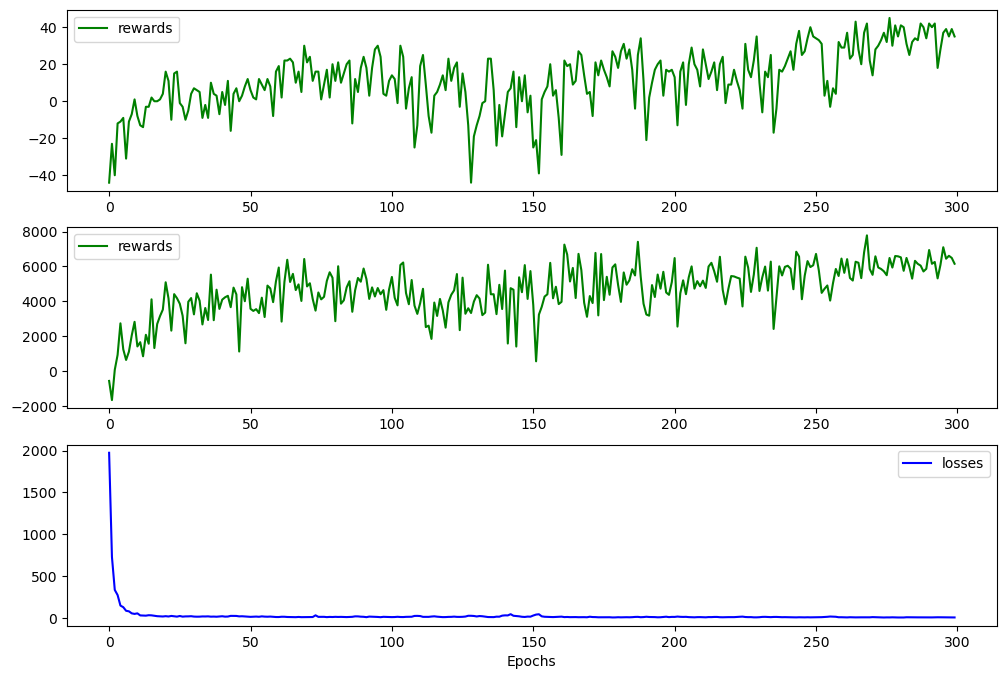

In [60]:
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(rewards, label="rewards", color="green")
plt.legend()

plt.subplot(3,1,2)
plt.plot(rewards_raw, label="rewards", color="green")
plt.legend()

plt.subplot(3,1,3)
plt.plot(losses, label="losses", color="blue")

plt.xlabel("Epochs")
plt.legend()
plt.show()

### Test

In [84]:
# Tester l'agent sur un environnement non vu (data_test)
env_test = Environment(data_test, history_t=30)
obs = env_test.reset()
done = False
total_profit = 0
total_raw_profit = 0
actions_taken = []
rewards_test = []
rewards_raw_test = []

R_port_test = {}  # Dictionnaire des rendements par période
current_date = env_test.t  # Date actuelle dans les données
daily_profits = []  # Liste des profits par jour

while not done:
    action = trader.select_action(obs)  # Utilisation du modèle appris
    obs, reward, done, reward_raw = env_test.step(action)

    total_profit += reward
    total_raw_profit += reward_raw
    rewards_test += [total_profit]
    rewards_raw_test += [total_raw_profit]
    actions_taken.append(action)

    # Obtenir la date actuelle
    new_date = env_test.t

    # Vérifier si on change de jour
    if new_date != current_date:
        if daily_profits:  # Si des trades ont été faits sur cette période
            R_port_test[current_date] = np.mean(daily_profits)  # Moyenne des profits par période
        daily_profits = []  # Réinitialiser la liste
        current_date = new_date  # Mettre à jour la date

    # Ajouter le profit du trade en cours
    daily_profits.append(reward)

# Ajouter la dernière période
if daily_profits:
    R_port_test[current_date] = np.mean(daily_profits)

print(f"Reward total sur données test : {total_profit}")
print(f"Actions prises : {actions_taken}")
print(f"Profit final : {env_test.profits}")
print(f"R_port (rendements normalisés par période) : {R_port_test}")


Reward total sur données test : -9.0
Actions prises : [2, 0, 2, 2, 2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 1, 2, 1, 1, 2, 2, 1, 0, 0, 1, 0, 0, 0, 2, 0, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 2, 0, 1, 0, 0, 1, 0, 1, 1, 2, 0, 1, 2, 2, 2, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Profit final : 1152.7216877441406
R_port (rendements normalisés par période) : {1: np.float64(-1.0), 2: np.float64(0.0), 3: np.float64(-1.0), 4: np.float64(-1.0), 5: np.float64(-1.0), 6: np.float64(0.0), 7: np.float64(-1.0), 8: np.float64(0.0), 9: np.float64(1.0), 10: np.float64(-1.0), 11: np.float64(-1.0), 12: np.float64(0.0), 13: np.float64(-1.0), 14: np.float64(-1.0), 15: np.float64(0.0), 16: np.float64(-1.0), 17: np.float64(0.0), 18: np.float64(-1.0), 19: np.float64(-1.0), 20: np.float64(-1.0), 21: np.float64(0.0), 22: np.float64(0.0), 23: np.float64(0.0), 24: np.float64(-1.0), 25: np.float64(-1.0), 26: np.float64(0.0), 27: np.float64(1.0), 28: np.float64(0.0), 29: np.float64(0.0), 30: np.float64(1.0), 31: np.

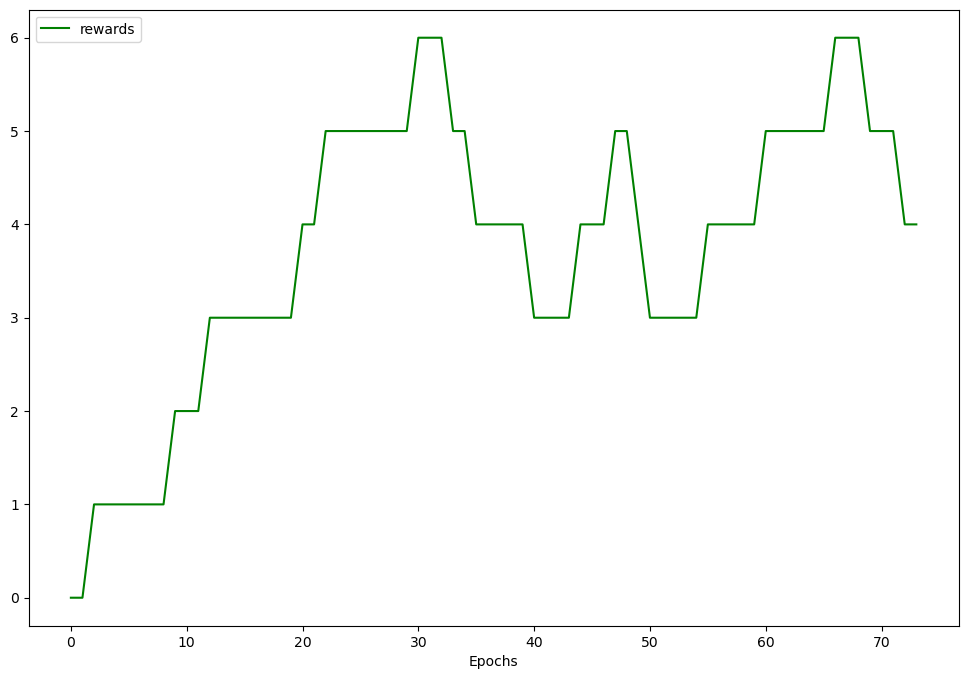

In [63]:
plt.figure(figsize=(12,8))
plt.plot(rewards_test, label="rewards", color="green")
plt.xlabel("Epochs")
plt.legend()
plt.show()

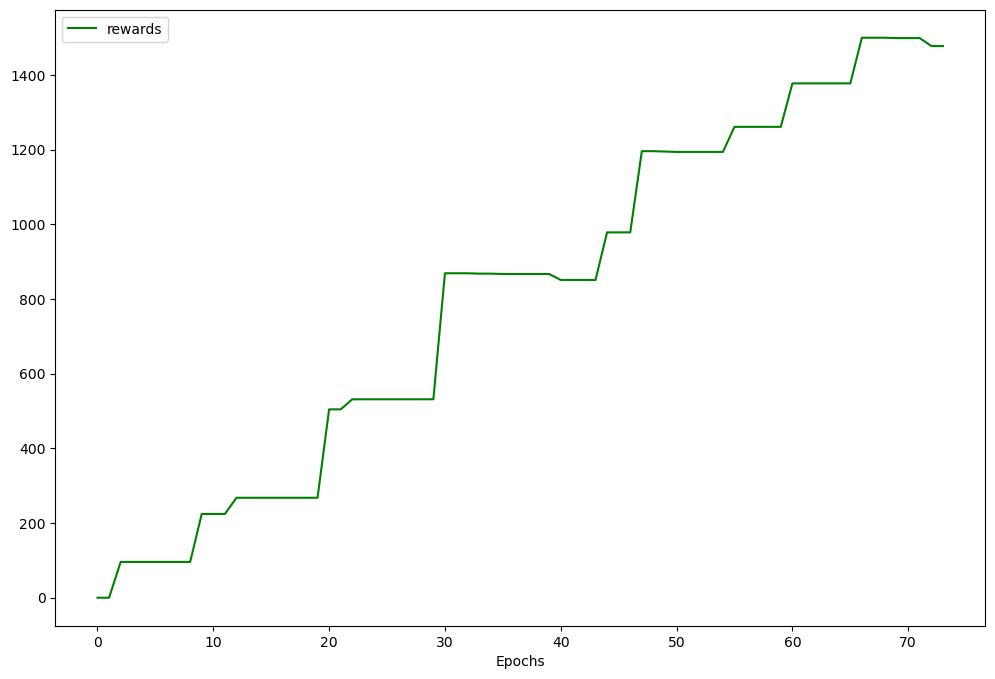

In [62]:
plt.figure(figsize=(12,8))
plt.plot(rewards_raw_test, label="rewards", color="green")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [64]:
# Fonction pour calculer la métrique E(R) (annualised expected trade return)
def annualised_expected_return(profits, num_trades):
    return np.mean(profits) * 252 / num_trades  # 252 jours de trading par an

# Fonction pour calculer la métrique std(R) (annualised standard deviation of trade return)
def annualised_std_return(profits, num_trades):
    return np.std(profits) * np.sqrt(252 / num_trades)  # Annualisation de la volatilité

# Fonction pour calculer la Downside Deviation (DD)
def downside_deviation(profits, num_trades):
    negative_returns = [r for r in profits if r < 0]
    if len(negative_returns) == 0:
        return 0.0
    return np.std(negative_returns) * np.sqrt(252 / num_trades)

# Fonction pour calculer la Sharpe Ratio
def sharpe_ratio(expected_return, std_return):
    return expected_return / std_return if std_return != 0 else 0.0

# Fonction pour calculer la Sortino Ratio
def sortino_ratio(expected_return, downside_deviation):
    return expected_return / downside_deviation if downside_deviation != 0 else 0.0

# Fonction pour calculer le Maximum Drawdown (MDD)
def max_drawdown(profits):
    cumulative_returns = np.cumsum(profits)
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = (cumulative_returns - running_max) / running_max
    return drawdowns.min()  # Le MDD est la perte maximale

# Fonction pour calculer la Calmar Ratio
def calmar_ratio(expected_return, mdd):
    return expected_return / abs(mdd) if mdd != 0 else 0.0

# Fonction pour calculer le pourcentage de retours positifs
def percent_positive_returns(profits):
    positive_returns = [r for r in profits if r > 0]
    return len(positive_returns) / len(profits) * 100

# Fonction pour calculer le ratio entre les retours positifs et négatifs
def ave_p_ave_l(profits):
    positive_returns = [r for r in profits if r > 0]
    negative_returns = [r for r in profits if r < 0]
    
    if len(negative_returns) == 0:
        return np.inf  # Éviter la division par zéro, retourne l'infini si pas de perte
    
    avg_positive = np.mean(positive_returns) if len(positive_returns) > 0 else 0
    avg_negative = np.mean(negative_returns) if len(negative_returns) > 0 else 0
    
    return avg_positive / abs(avg_negative)

# Fonction principale pour calculer toutes les métriques
def calculate_metrics(profits):
    num_trades = len(profits)
    
    expected_return = annualised_expected_return(profits, num_trades)
    std_return = annualised_std_return(profits, num_trades)
    dd = downside_deviation(profits, num_trades)
    sharpe = sharpe_ratio(expected_return, std_return)
    sortino = sortino_ratio(expected_return, dd)
    mdd = max_drawdown(profits)
    calmar = calmar_ratio(expected_return, mdd)
    positive_pct = percent_positive_returns(profits)
    ave_p_ave_l_ratio = ave_p_ave_l(profits)
    
    metrics = {
        "E(R)": expected_return,
        "std(R)": std_return,
        "Downside Deviation (DD)": dd,
        "Sharpe Ratio": sharpe,
        "Sortino Ratio": sortino,
        "MDD": mdd,
        "Calmar Ratio": calmar,
        "% +ve Returns": positive_pct,
        "Ave. P / Ave. L": ave_p_ave_l_ratio
    }
    
    return metrics

In [ ]:
# Train
profits_test = list(R_port.values())  # C'est la liste cumulative des profits du test

# Calcul des métriques
metrics = calculate_metrics(profits_test)

# Affichage des résultats
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

E(R): 28.0793
std(R): 50.7820
Downside Deviation (DD): 7.9429
Sharpe Ratio: 0.5529
Sortino Ratio: 3.5351
MDD: nan
Calmar Ratio: nan
% +ve Returns: 53.1429
Ave. P / Ave. L: 6.8166


C:\Users\planc\AppData\Local\Temp\ipykernel_3916\3548557893.py:28: RuntimeWarning: divide by zero encountered in divide
  drawdowns = (cumulative_returns - running_max) / running_max
C:\Users\planc\AppData\Local\Temp\ipykernel_3916\3548557893.py:28: RuntimeWarning: invalid value encountered in divide
  drawdowns = (cumulative_returns - running_max) / running_max


In [85]:
# Test
profits_test = list(R_port_test.values())  # C'est la liste cumulative des profits du test

# Calcul des métriques
metrics = calculate_metrics(profits_test)

# Affichage des résultats
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

E(R): -0.4142
std(R): 1.0919
Downside Deviation (DD): 0.0000
Sharpe Ratio: -0.3793
Sortino Ratio: 0.0000
MDD: -0.0000
Calmar Ratio: 0.0000
% +ve Returns: 12.1622
Ave. P / Ave. L: 1.0000


In [55]:
# TODO : implémenter un agent plus complexe, avec un réseau plus profond, et des features plus avancées.
# TODO : optimiser les hyperparamètres (grid search, etc.)
# TODO : ajouter des features (volatilité, etc.)
# TODO : ajouter une manière d'acheter plusieurs action à la fois (quantité variable)
# TODO : ajouter des frais de transaction
# TODO : Augmenter la fréquence de trading (intraday) et de points
# TODO : ajouter un stop-loss sur les positions
# TODO : ajouter un take-profit
# TODO : ajouter un système de récompense plus complexe
# TODO : ajouter une courbe de performance (capital cumulé)
# TODO : ajouter une visualisation des trades (graphique)
# TODO : ajouter une visualisation des rewards (graphique)
# TODO : ajouter une visualisation des pertes (graphique)
# TODO : ajouter un système de logging (TensorBoard, etc.)
# TODO : ajouter une sauvegarde du modèle
# TODO : ajouter un système de validation (early stopping)
# TODO : ajouter un système de rendu vidéo (Gym)
# TODO : essayer sur d'autres actifs (forex, crypto, etc.)
# TODO : essayer sur d'autres environnements (Gym)
# TODO : essayer d'autres algorithmes (PPO, DDPG, etc.)
# TODO : essayer d'autres techniques de deep learning (LSTM, etc.)
# TODO : essayer d'autres techniques de reinforcement learning (DQN, etc.)
# TODO : essayer d'autres techniques de trading (pairs trading, etc.)
# TODO : CNN dont la loss est f(xi) - somme des différences croissantes
# TODO : Rajouter le volume dans les features
# TODO : Rajouter des features de volatilité
# TODO : Rajouter des features de momentum
# TODO : Rajouter des features de tendance
# TODO : Rajouter des features de support et résistance
# TODO : Rajouter des features de gap
# TODO : Rajouter des features de chandeliers japonais
# TODO : Rajouter des features de pattern recognition
# TODO : Rajouter des features de news sentiment
# TODO : Rajouter des features de sentiment analysis
# TODO : Rajouter des features de macroéconomie
# TODO : Rajouter des features de microéconomie
# TODO : Rajouter des features de taux d'intérêt
